In [1]:
import mlx.core as mx
import mlx.nn as nn
from mlx.data import datasets
import mlx.optimizers as optim
import numpy as np

In [2]:
# Import local module
from datasets_utils import cifar100

cifar100_train = datasets.load_cifar100(train=True)
cifar100_test = datasets.load_cifar100(train=False)

len(cifar100_train), len(cifar100_test)

(50000, 10000)

In [3]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    mean = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
    std = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

    def normalize(x):
        x = x.astype("float32") / 255.0
        return (x - mean) / std

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", normalize)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

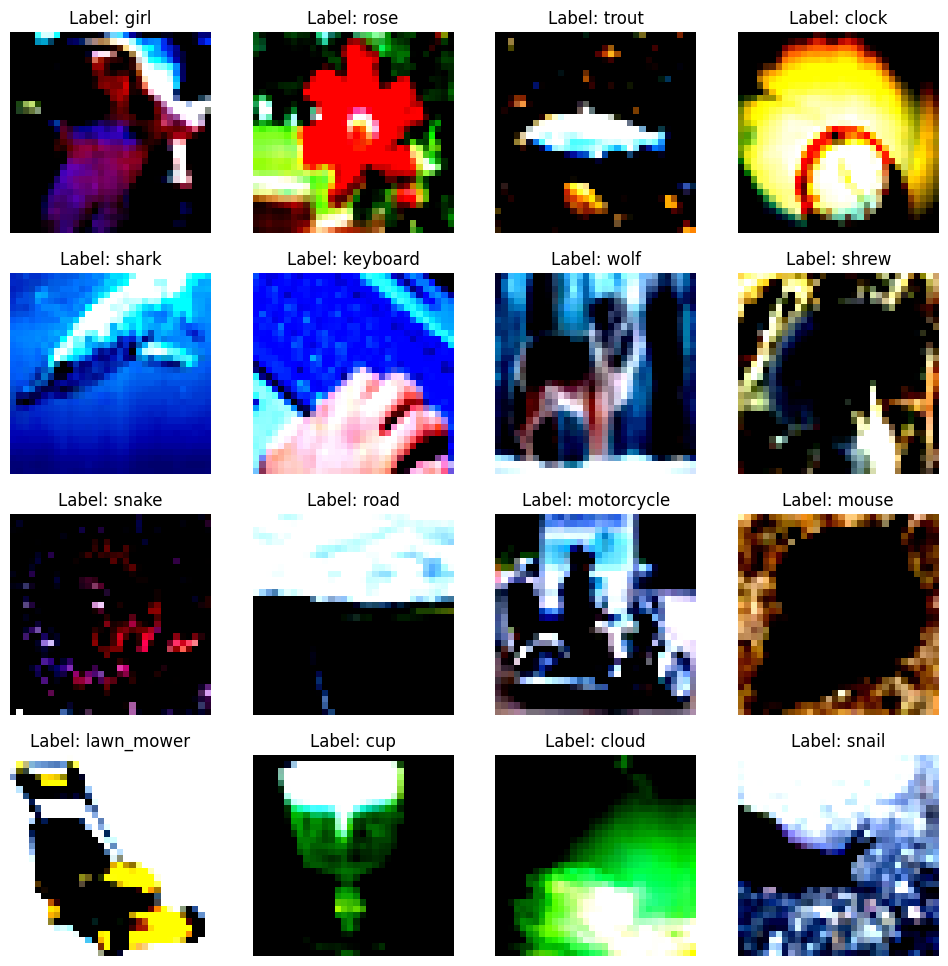

In [4]:
import matplotlib.pyplot as plt
# Visualize image samples
mx.random.seed(42)

n_cols = 4
n_rows = 4
fig = plt.figure(figsize=(12, 12))
for i, batch in zip(range(n_cols * n_rows), get_streamed_data(cifar100_train, batch_size=1)):    
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    img = mx.array(batch["image"])
    label = batch["label"].squeeze()
    label = cifar100.labels[label]
    img = img.astype(mx.float32)
    ax.set_title(f"Label: {label}")
    ax.set_axis_off()
    ax.imshow(img.squeeze())
plt.show()

In [5]:
# Adopt TinyVGG architecture, but in MLX
class Model(nn.Module):
    def __init__(self, input_channel, input_width, conv_filters, output_dims):
        super().__init__()
        conv2d_kernel_size = 3
        conv2d_stride = 1
        conv2d_padding = 0

        pool2d_kernel_size = 2
        pool2d_stride = 2
        pool2d_padding = 0

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channel,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(input_dims=5*5*conv_filters, output_dims=output_dims),
        )

    def __call__(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = mx.flatten(x, start_axis=1, end_axis=-1)
        x = self.fully_connected(x)
        return x

In [6]:
NUM_CLASSES = len(cifar100.labels)
INPUT_WIDTH = 32
INPUT_CHANNEL = 3
CONV_FILTERS = 128

model = Model(
    input_channel=INPUT_CHANNEL,
    input_width=INPUT_WIDTH,
    conv_filters=CONV_FILTERS,
    output_dims=NUM_CLASSES
)

mx.eval(model)
model

Model(
  (conv_layer1): Sequential(
    (layers.0): Conv2d(3, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (conv_layer2): Sequential(
    (layers.0): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(128, 128, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (fully_connected): Sequential(
    (layers.0): Linear(input_dims=3200, output_dims=100, bias=True)
  )
)

In [ ]:
import trainer

epochs = 500
optimizer = optim.Adam(learning_rate=0.0001)

train_data = get_streamed_data(batch_size=256, data=cifar100_train, shuffled=True)
test_data = get_streamed_data(batch_size=256, data=cifar100_test, shuffled=False)

for epoch in range(epochs):
    train_loss, train_acc, throughput = trainer.train_epoch(model, train_data, optimizer, epoch, verbose=False)
    print(" | ".join(
                (
                    f"Epoch: {epoch}",
                    f"avg. Train loss {train_loss.item():.3f}",
                    f"avg. Train acc {train_acc.item():.3f}",
                    f"Throughput: {throughput.item():.2f} images/sec",
                )))
    test_acc = trainer.test_epoch(model, test_data, epoch)
    print(f"Epoch: {epoch} | Test acc {test_acc.item():.3f}")
    train_data.reset()
    test_data.reset()

Epoch: 0 | avg. Train loss 4.569 | avg. Train acc 0.052 | Throughput: 1380.25 images/sec
Epoch: 0 | Test acc 0.064
Epoch: 1 | avg. Train loss 4.556 | avg. Train acc 0.066 | Throughput: 1432.89 images/sec
Epoch: 1 | Test acc 0.068
Epoch: 2 | avg. Train loss 4.550 | avg. Train acc 0.072 | Throughput: 1429.22 images/sec
Epoch: 2 | Test acc 0.075
Epoch: 3 | avg. Train loss 4.541 | avg. Train acc 0.080 | Throughput: 1429.54 images/sec
Epoch: 3 | Test acc 0.082
Epoch: 4 | avg. Train loss 4.537 | avg. Train acc 0.085 | Throughput: 1430.79 images/sec
Epoch: 4 | Test acc 0.088
Epoch: 5 | avg. Train loss 4.533 | avg. Train acc 0.089 | Throughput: 1429.96 images/sec
Epoch: 5 | Test acc 0.086
Epoch: 6 | avg. Train loss 4.529 | avg. Train acc 0.093 | Throughput: 1429.62 images/sec
Epoch: 6 | Test acc 0.091
Epoch: 7 | avg. Train loss 4.524 | avg. Train acc 0.098 | Throughput: 1428.07 images/sec
Epoch: 7 | Test acc 0.096
Epoch: 8 | avg. Train loss 4.522 | avg. Train acc 0.100 | Throughput: 1427.40 im

In [ ]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
model.eval()
for batch in test_data:
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

test_data.reset()